In [1]:
# see Leo's analysis here: https://github.com/saezlab/best_practices_ParTIpy/tree/main
from pathlib import Path
import plotnine as pn
import scanpy as sc
import partipy as pt

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from mizani.bounds import squish
import decoupler as dc
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import harmonypy as hm


figure_dir = Path("figures") / "fibroblast_cross_condition"
figure_dir.mkdir(exist_ok=True, parents=True)
sc.settings.figdir = figure_dir

output_dir = Path("output") / "fibroblast_cross_condition"
output_dir.mkdir(exist_ok=True, parents=True)

adata = pt.read_h5ad("/home/pschaefer/fibroblast_cross_condition_partipy.h5ad")

ho = hm.run_harmony(adata.obsm["X_pca"], adata.obs[["donor_id"]], "donor_id")
adata.obsm["X_pca_harmony"] = ho.Z_corr.copy()
del ho

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
2026-02-03 11:57:24,162 - harmonypy - INFO - Running Harmony (PyTorch on cuda)
2026-02-03 11:57:24 | [INFO] Running Harmony (PyTorch on cuda)
2026-02-03 11:57:24,165 - harmonypy - INFO -   Parameters:
2026-02-03 11:57:24 | [INFO]   Parameters:
2026-02-03 11:57:24,166 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-03 11:57:24 | [INFO]     max_iter_harmony: 10
2026-02-03 11:57:24,167 - harmonypy - INFO -     max_iter

In [ ]:
from scipy.spatial import ConvexHull
import harmonypy as hm
from scipy.optimize import linear_sum_assignment

color_dict = {
    "NF": "#01665E",  # teal (blue-green)
    "CM": "#8C510A",  # brown
}

# 0) setting
patient_col = "donor_id"
y_col = "disease"
y_col_one = "CM"
base_covars = ["sex"]

# guard: ensure covariates exist; coerce object covariates to categorical
for c in base_covars:
    if c not in adata.obs.columns:
        raise KeyError(
            f"Covariate '{c}' not found in adata.obs columns: {list(adata.obs.columns)}"
        )
    if str(adata.obs[c].dtype) == "object":
        adata.obs[c] = adata.obs[c].astype("category")

# 1) get the archetypes
aa_results_dict = pt.get_aa_result(adata, n_archetypes=4)
Z = aa_results_dict["Z"].copy().astype(np.float32)
archetype_df = pd.DataFrame(
    Z, columns=[f"pc_{arch_idx}" for arch_idx in range(Z.shape[1])]
)
archetype_df["archetype"] = [f"{idx}" for idx in range(len(archetype_df))]
print(aa_results_dict.keys())
print(f"{Z.shape=}")

# 2) get the single-cell data (note adata.uns["AA_config"]["n_dimensions"] is a list of ints)
X = (
    adata.obsm[adata.uns["AA_config"]["obsm_key"]][
        :, adata.uns["AA_config"]["n_dimensions"]
    ]
    .copy()
    .astype(np.float32)
)
print(f"{X.shape=}")

# 3) aggregate per patient
cols_to_check = base_covars + [y_col] + [patient_col]
nuniq = adata.obs.groupby(patient_col)[cols_to_check].nunique(dropna=False)
assert (nuniq.max() <= 1).all(), (
    f"Non-unique covariates within sample_id:\n{nuniq.max()[nuniq.max() > 1]}"
)
obs_agg = adata.obs[cols_to_check].drop_duplicates().copy()
X_agg = np.zeros((len(obs_agg), X.shape[1]), dtype=np.float32)
for idx, smp_id in enumerate(obs_agg[patient_col]):
    X_agg[idx, :] = X[adata.obs[patient_col] == smp_id, :].mean(axis=0)
print(f"{X_agg.shape=}")

# 4) project onto the convex hull
AA_model = pt.AA(n_archetypes=len(Z))
AA_model.Z = Z
AA_model.n_samples = len(X_agg)
X_agg_proj = AA_model.transform(X_agg)
assert np.all(np.isclose(X_agg_proj.sum(axis=1), 1))
assert np.all(X_agg_proj >= 0)
print(f"{X_agg_proj.shape=}")
X_agg_conv = X_agg_proj @ Z
print(f"{X_agg_conv.shape=}")

# 5) add first 3 pcs to obs_agg for plotting
for pc_idx in [0, 1, 2]:
    obs_agg[f"pc_{pc_idx}"] = X_agg_conv[:, pc_idx]

# O) plotting
hull_df = None
if len(archetype_df) >= 3:
    hull = ConvexHull(archetype_df[["pc_0", "pc_1"]].to_numpy())
    hull_points = archetype_df.iloc[hull.vertices][["pc_0", "pc_1"]]
    hull_df = pd.concat([hull_points, hull_points.iloc[:1]], ignore_index=True)
p = (
    (
        pn.ggplot()
        + pn.geom_point(data=obs_agg, mapping=pn.aes(x="pc_0", y="pc_1", color=y_col))
        + pn.geom_point(
            data=archetype_df,
            mapping=pn.aes(x="pc_0", y="pc_1"),
            color="grey",
            alpha=0.5,
            size=2,
        )
        + pn.geom_label(
            data=archetype_df,
            mapping=pn.aes(x="pc_0", y="pc_1", label="archetype"),
            color="black",
            fill="white",
            boxcolor="black",
            label_r=0.2,
            label_padding=0.2,
            label_size=0.7,
            size=20,
        )
    )
    + pn.theme_bw()
    + pn.scale_color_manual(values=color_dict)
)
if hull_df is not None:
    p += pn.geom_path(
        data=hull_df,
        mapping=pn.aes(x="pc_0", y="pc_1"),
        color="grey",
        size=1.2,
        alpha=0.5,
    )
p.save(figure_dir / "patient_pseudobulk_in_convex_hull.pdf", verbose=False)

# 6) compute the distance matrix
dist_key = "euclidean"
D = cdist(XA=X_agg_conv, XB=Z, metric=dist_key)
print(f"{D.shape=}")

# 7) add distance to the dataframe
for arch_idx in range(len(Z)):
    obs_agg[f"dist_to_arch_{arch_idx}"] = D[:, arch_idx]

# 8) prepare covariates
cat_covars = [c for c in base_covars if str(obs_agg[c].dtype) in ("object", "category")]
num_covars = [c for c in base_covars if c not in cat_covars]

dict_keys(['A', 'B', 'RSS', 'RSS_full', 'Z', 'cell_index', 'varexpl'])
Z.shape=(4, 16)
X.shape=(147219, 16)
X_agg.shape=(42, 16)
X_agg_proj.shape=(42, 4)
X_agg_conv.shape=(42, 16)


/tmp/ipykernel_2905790/1270839963.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


D.shape=(42, 4)


In [45]:
p = (
    pn.ggplot(plot_df)
    + pn.geom_point(
        pn.aes(x="disease", y="value", color="disease"),
        position=pn.position_jitter(width=0.10, height=0),
        size=2,
        alpha=0.5,
    )
    + pn.facet_wrap("variable_clean", ncol=4)
    + pn.scale_color_manual(values=color_dict)
    + pn.theme_bw()
    + pn.theme(
        figure_size=(6, 3),
        strip_background=pn.element_rect(fill="white", color="black"),
        strip_text=pn.element_text(color="black"),
    )
    + pn.labs(x="Disease Status", y="Distance")
)
p.save(figure_dir / "patient_pseudobulk_distance_plot.pdf", verbose=False)

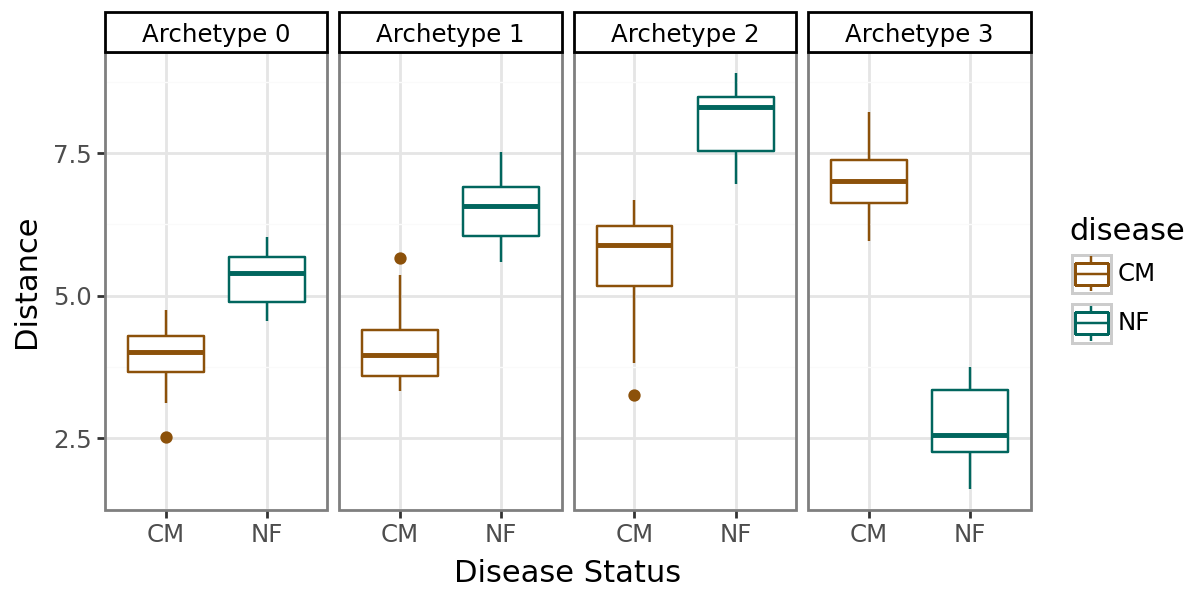

In [47]:
p = (
    pn.ggplot(plot_df)
    + pn.geom_boxplot(
        pn.aes(x="disease", y="value", color="disease"),
    )
    + pn.facet_wrap("variable_clean", ncol=4)
    + pn.scale_color_manual(values=color_dict)
    + pn.theme_bw()
    + pn.theme(
        figure_size=(6, 3),
        strip_background=pn.element_rect(fill="white", color="black"),
        strip_text=pn.element_text(color="black"),
    )
    + pn.labs(x="Disease Status", y="Distance")
)
#p.save(figure_dir / "patient_pseudobulk_distance_boxplot.pdf", verbose=False)
p.show()

In [ ]:
gene_mask = adata.var.index[adata.var["n_cells"] > 100].to_list()

adata_default = adata.copy()
del (
    adata_default.uns["AA_results"],
    adata_default.uns["AA_config"],
    adata_default.uns["AA_bootstrap"],
    adata_default.uns["AA_cell_weights"],
    adata_default.uns["AA_pca"],
    adata_default.uns["AA_selection_metrics"],
)
pt.set_obsm(adata=adata_default, obsm_key="X_pca", n_dimensions=16)
pt.compute_archetypes(adata_default, n_archetypes=4)
pt.compute_archetype_weights(adata_default, result_filters={"n_archetypes": 4})
weights = pt.get_aa_cell_weights(adata_default, n_archetypes=4)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)
archetype_expression_default = pt.compute_archetype_expression(
    adata=adata_default, layer="z_scaled"
)

adata_harmony = adata.copy()
del (
    adata_harmony.uns["AA_results"],
    adata_harmony.uns["AA_config"],
    adata_harmony.uns["AA_bootstrap"],
    adata_harmony.uns["AA_cell_weights"],
    adata_harmony.uns["AA_pca"],
    adata_harmony.uns["AA_selection_metrics"],
)
pt.set_obsm(adata=adata_harmony, obsm_key="X_pca_harmony", n_dimensions=16)
pt.compute_archetypes(adata_harmony, n_archetypes=4)
pt.compute_archetype_weights(adata_harmony, result_filters={"n_archetypes": 4})
weights = pt.get_aa_cell_weights(adata_harmony, n_archetypes=4)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)
archetype_expression_harmony = pt.compute_archetype_expression(
    adata=adata_harmony, layer="z_scaled"
)

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/p

Applied length scale is 2.59.


/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
/home/pschaefer/miniforge3/envs/partipy/

Applied length scale is 2.28.


In [ ]:
gene_mask = adata.var.index[adata.var["n_cells"] > 100].to_list()

archetype_expression_default = pt.compute_archetype_expression(
    adata=adata_default, layer="z_scaled"
)[gene_mask]

archetype_expression_harmony = pt.compute_archetype_expression(
    adata=adata_harmony, layer="z_scaled"
)[gene_mask]

In [ ]:
dist = cdist(
    archetype_expression_default, archetype_expression_harmony, metric="cosine"
)
_ref_idx, query_idx = linear_sum_assignment(dist)

archetype_expression_aligned_a = (
    archetype_expression_default.loc[_ref_idx, :].to_numpy().copy()
)
archetype_expression_aligned_b = (
    archetype_expression_harmony.loc[query_idx, :].to_numpy().copy()
)

pearson_r, pearson_pvals = pearsonr_per_row(
    archetype_expression_aligned_a, archetype_expression_aligned_b, return_pval=True
)

In [ ]:
pearson_r, pearson_pvals = pearsonr_per_row(
    archetype_expression_aligned_a, archetype_expression_aligned_b, return_pval=True
)

In [16]:
archetype_expression_harmony.loc[query_idx, :]

,AL627309.1,AL627309.5,AP006222.2,LINC01409,FAM87B,LINC01128,LINC00115,AL645608.6,LINC02593,SAMD11,...,MT-ND4,MT-ND5,MT-ND6,MT-CYB,BX004987.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1
0,-0.018924,-0.020142,-0.018648,-0.012288,-0.018099,0.004245,-0.021436,-0.024998,-0.020631,0.000335,...,0.088406,0.089022,0.111841,0.126197,-0.019425,-0.020727,-0.018445,-0.010552,-0.014041,-0.011173
1,-0.019397,-0.016044,-0.017392,0.000595,-0.017504,-0.031942,-0.019049,-0.024508,-0.035815,-0.048738,...,-0.047148,-0.046497,-0.042897,-0.045276,-0.020722,-0.021538,-0.006767,-0.009250,0.004601,-0.015479
3,-0.021420,-0.018675,-0.019065,0.027975,-0.019893,-0.008604,-0.026475,-0.020689,-0.003795,0.031303,...,-0.036310,-0.045958,-0.065215,-0.045288,-0.021703,-0.021309,-0.012191,-0.017219,0.005890,-0.000777
2,-0.020219,-0.024051,-0.016782,-0.020533,-0.017949,0.018312,-0.015986,-0.013635,-0.011325,0.011188,...,0.002282,0.009450,0.034316,0.007613,-0.019169,-0.023533,-0.019640,-0.000543,-0.001942,-0.018968


In [28]:
dist = cdist(
    archetype_expression_default, archetype_expression_harmony, metric="correlation"
)
corr = 1 - dist
_ref_idx, query_idx = linear_sum_assignment(dist)

archetype_expression_aligned_a = (
    archetype_expression_default.loc[_ref_idx, :].to_numpy().copy()
)
archetype_expression_aligned_b = (
    archetype_expression_harmony.loc[query_idx, :].to_numpy().copy()
)

pearson_r, pearson_pvals = pearsonr_per_row(
    archetype_expression_aligned_a, archetype_expression_aligned_b, return_pval=True
)

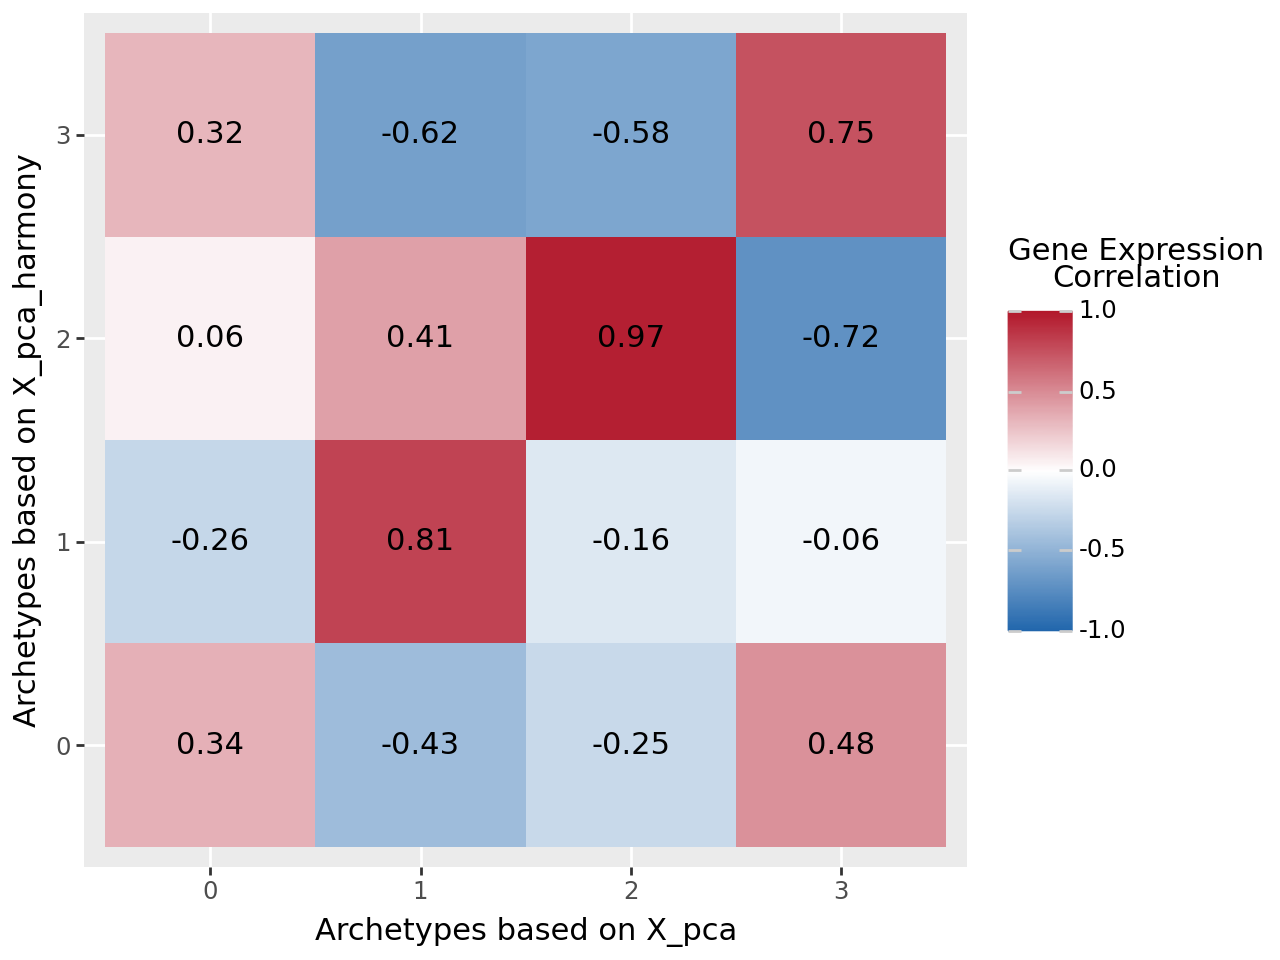

In [ ]:
plot_df = (
    pd.DataFrame(
        corr[:, query_idx],
        index=[f"{idx}" for idx in range(4)],
        columns=[f"{idx}" for idx in range(4)],
    )
    .reset_index(names="x")
    .melt(id_vars="x", var_name="y", value_name="correlation")
)
plot_df

p = (
    pn.ggplot(plot_df)
    + pn.geom_tile(pn.aes(x="x", y="y", fill="correlation"))
    + pn.geom_text(pn.aes(x="x", y="y", label="correlation"), format_string="{:.2f}")
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        limits=(-1.0, 1.0),
        oob=squish,
    )
    + pn.labs(
        x="Archetypes based on X_pca",
        y="Archetypes based on X_pca_harmony",
        fill="Gene Expression\nCorrelation",
    )
)
p.show()

In [49]:
adata.obsm["X_pca"].shape

(147219, 50)

In [52]:
adata.obs["SubCluster"].value_counts()

SubCluster
FB-TLL2       52993
FB-ActFB      32267
FB-ZBTB7C     30618
FB-CNTNAP2    19885
FB-X1          9101
FB-PTCHD4      2355
Name: count, dtype: int64

In [ ]:
plot_df = (
    pd.DataFrame(
        corr[:, query_idx],
        index=[f"ref_arch_{idx}" for idx in range(4)],
        columns=[f"query_arch_{idx}" for idx in range(4)],
    )
    .reset_index(names="x")
    .melt(id_vars="x", var_name="y", value_name="correlation")
)
plot_df

,x,y,correlation
0,ref_arch_0,query_arch_0,0.338470
1,ref_arch_1,query_arch_0,-0.433891
2,ref_arch_2,query_arch_0,-0.250796
3,ref_arch_3,query_arch_0,0.476681
4,ref_arch_0,query_arch_1,-0.259604
5,ref_arch_1,query_arch_1,0.808712
6,ref_arch_2,query_arch_1,-0.155713
7,ref_arch_3,query_arch_1,-0.058870
8,ref_arch_0,query_arch_2,0.058407
9,ref_arch_1,query_arch_2,0.411942


In [29]:
corr[_ref_idx, query_idx]

array([0.33847036, 0.80871192, 0.9711187 , 0.74550501])

In [ ]:
corr = 1 - dist

array([[ 0.33847036, -0.25960365,  0.31797455,  0.05840742],
       [-0.43389056,  0.80871192, -0.62186589,  0.41194188],
       [-0.25079645, -0.15571312, -0.58062529,  0.9711187 ],
       [ 0.47668128, -0.05886988,  0.74550501, -0.7169342 ]])

In [13]:
_ref_idx

array([0, 1, 2, 3])

In [11]:
dist

array([[0.5883363 , 0.95138885, 0.59343742, 0.79462403],
       [1.29864871, 0.16290373, 1.45603717, 0.52916566],
       [1.20571147, 1.08027995, 1.51531705, 0.03787255],
       [0.53244125, 1.04279351, 0.27622165, 1.68110985]])

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import partipy as pt
import plotnine as pn
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


In [3]:
archetype_expression_default.shape

(4, 28616)

In [4]:
archetype_expression_harmony.shape

(4, 28616)

In [ ]:
msigdb_raw = dc.op.resource("MSigDB")
msigdb_raw = msigdb_raw[~msigdb_raw.duplicated(["geneset", "genesymbol"])].copy()

In [ ]:
marker_blocks = {
    0: {
        "function": "quiescent / signaling; axon-guidance & ion-channel enriched",
        "genes": [
            "NRP1",
            "CNTNAP2",
            "SLIT3",
            "KCND2",
            "KCND3",
            "CACNA2D3",
            "ANK3",
            "FBLN1",
            # "LSAMP",
            # "NAV3",
            # "FLRT2",
            # "GRID2",
            # "ANK2",
            # "PDZRN4",
            # "SMAD6",
            # "BICC1",
        ],
        "TFs": [
            "NR2F2",  # vascular / mesenchymal lineage
            "EMX2",  # developmental patterning
            "SP1",  # basal transcription / promoter occupancy
            "LMO2",  # lineage regulation
            "BRCA1",  # genome integrity / quiescence
            "PROX1",  # fibroblast / vascular identity
            "TP53",  # stress surveillance
            "SRF",  # structural maintenance (low-activation context)
        ],
    },
    1: {
        "function": "perivascular / vessel-associated fibroblasts",
        "genes": [
            "COL15A1",
            "COLEC12",
            "FREM1",
            "PDE5A",
            "KCNMB2",
            "KCNN3",
            "SOX6",
            "TCF4",
        ],
        "TFs": [
            "RORA",  # niche / circadian modulation
            "LHX3",  # developmental patterning
            "ATOH1",  # differentiation control
            "MKX",  # fibroblast identity restraint
            "ETV6",  # vascular-associated regulation
            "KLF17",  # anti-activation TF
            "NEUROD2",  # positional identity reuse
            "HOXA5",  # anterior–posterior patterning
        ],
    },
    2: {
        "function": "activated fibroblast → myofibroblast / matrifibrocyte axis (fibrotic ECM)",
        "genes": [
            "POSTN",
            "THBS4",
            "FAP",
            "COL22A1",
            "AEBP1",
            "ITGA10",
            "LTBP2",
            "WISP2",
        ],
        "TFs": [
            "MYF5",  # deep mesenchymal program
            "TWIST1",  # EMT / activation
            "BHLHA15",  # differentiation switch
            "SCX",  # myofibroblast / tendon-like program
            "SRF",  # contractility (high-activation context)
            "KDM2A",  # chromatin remodeling
            "KAT6A",  # histone acetylation
            "JUNB",  # immediate-early activation
        ],
    },
    3: {
        "function": "stress-responsive / metabolic activation (redox, hypoxia, detox)",
        "genes": [
            "FKBP5",
            "HIF3A",
            "TXNRD1",
            "GPX3",
            "NNMT",
            "MGST1",
            "CFD",
            "GLUL",
            # "ADH1B",
        ],
        "TFs": [
            "NR3C1",  # glucocorticoid stress response (strongest overall)
            "HIF1A",  # hypoxia
            "PPARD",  # lipid metabolism
            "NFKB",  # inflammation
            "CEBPB",  # inflammatory transcription
            "MYC",  # metabolic scaling
            "NFE2L2",  # oxidative stress (NRF2)
            "FOXO3",  # stress resilience
        ],
    },
}
gene_list = []
for a in [0, 1, 2, 3]:
    gene_list += marker_blocks[a]["genes"]
# de-duplicate while preserving order
seen = set()
gene_list = [g for g in gene_list if not (g in seen or seen.add(g))]

tf_list = [tf for a in [0, 1, 2, 3] for tf in marker_blocks[a]["TFs"]]
seen = set()
tf_list = [tf for tf in tf_list if not (tf in seen or seen.add(tf))]

########################################################################
# Characterize archetypal gene expression
########################################################################
gene_mask = adata.var.index[adata.var["n_cells"] > 100].to_list()
archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")[
    gene_mask
]

arch_expr_long = archetype_expression.copy().T
arch_expr_long.columns = [f"arch_{c}" for c in arch_expr_long.columns]
arch_expr_long = arch_expr_long.reset_index(names="gene")
arch_expr_long = arch_expr_long.melt(id_vars="gene")
arch_expr_long.to_csv(output_dir / "arch_expr_long.csv", index=False)

plot_df = arch_expr_long.loc[arch_expr_long["gene"].isin(gene_list), :].copy()
plot_df["gene"] = pd.Categorical(plot_df["gene"], categories=gene_list, ordered=True)
arch_order = [f"arch_{idx}" for idx in range(4)]
plot_df["variable"] = pd.Categorical(
    plot_df["variable"], categories=arch_order, ordered=True
)
p = (
    pn.ggplot(plot_df, pn.aes(x="gene", y="variable", fill="value"))
    + pn.geom_tile()
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        limits=(-0.75, 0.75),
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        axis_text_x=pn.element_text(rotation=90, ha="center"),
        figure_size=(3, 8),
    )
    + pn.labs(x="Gene", y="Archetype", fill="Mean z-scored\nGene Expression")
    + pn.coord_flip()
)
p.save(figure_dir / "gene_expression_tile_plot.pdf", verbose=False)

########################################################################
# Characterize archetypal TF activation
########################################################################
collectri = dc.op.collectri(organism="human")
collectri_acts_ulm_est, collectri_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression, net=collectri, verbose=False
)

df_1 = collectri_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="TF", value_name="t_value"
)
df_2 = collectri_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="TF", value_name="p_value"
)
collectri_df = df_1.join(df_2.set_index(["archetype", "TF"]), on=["archetype", "TF"])
collectri_df.to_csv(output_dir / "collectri_df.csv", index=False)
del df_1, df_2

plot_df = collectri_df
plot_df = plot_df.loc[plot_df["TF"].isin(tf_list), :].copy()
plot_df["TF"] = pd.Categorical(plot_df["TF"], categories=tf_list, ordered=True)
arch_order = [f"{idx}" for idx in range(4)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)
p_sig = 0.05
sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()
p = (
    pn.ggplot(plot_df, pn.aes(x="TF", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(x="TF", y="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        axis_text_x=pn.element_text(rotation=90, ha="center"),
        figure_size=(3, 9),
    )
    + pn.labs(x="Gene", y="Archetype", fill="TF Activation\nt-value")
    + pn.coord_flip()
)
p.save(figure_dir / "tf_activation_tile_plot.pdf", verbose=False)

########################################################################
# Characterize archetypal pathway activation (using progeny)
########################################################################
collectri = dc.op.progeny(organism="human")
progeny_acts_ulm_est, progeny_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression, net=collectri, verbose=False
)

df_1 = progeny_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="pathway", value_name="t_value"
)
df_2 = progeny_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="pathway", value_name="p_value"
)
progeny_df = df_1.join(
    df_2.set_index(["archetype", "pathway"]), on=["archetype", "pathway"]
)
progeny_df.to_csv(output_dir / "progeny_df.csv", index=False)
del df_1, df_2

plot_df = progeny_df.copy()
arch_order = [f"{idx}" for idx in range(4)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"].astype(str), categories=arch_order, ordered=True
)

wide = plot_df.pivot(index="archetype", columns="pathway", values="t_value")
wide = wide.loc[arch_order, :]

# Data-driven ordering by clustering progeny pathways (optimal leaf ordering)
col_linkage = sch.linkage(
    pdist(wide.T, metric="euclidean"),
    method="average",
    optimal_ordering=True,
)
pathway_order = wide.columns[sch.leaves_list(col_linkage)].tolist()
plot_df["pathway"] = pd.Categorical(
    plot_df["pathway"], categories=pathway_order, ordered=True
)

sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()

p = (
    pn.ggplot(plot_df, pn.aes(x="pathway", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(x="pathway", y="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        axis_text_x=pn.element_text(rotation=90, ha="center"),
        figure_size=(6, 9),
    )
    + pn.labs(x="Pathway", y="Archetype", fill="Progeny Enrichment\nt-value")
    + pn.coord_flip()
)
p.save(figure_dir / "progeny_tile_plot.pdf", verbose=False)

########################################################################
# Characterize archetypal functions using MSigDB hallmarks
########################################################################
min_genes_per_pathway = 5
max_genes_per_pathway = np.inf

database = "hallmark"
msigdb = msigdb_raw[msigdb_raw["collection"] == database]
genesets_within_min = (
    (msigdb.value_counts("geneset") >= min_genes_per_pathway)
    .reset_index()
    .query("count")["geneset"]
    .to_list()
)
genesets_within_max = (
    (msigdb.value_counts("geneset") <= max_genes_per_pathway)
    .reset_index()
    .query("count")["geneset"]
    .to_list()
)
genesets_to_keep = list(set(genesets_within_min) & set(genesets_within_max))
msigdb = msigdb.loc[
    msigdb["geneset"].isin(genesets_to_keep), :
].copy()  # removing small gene sets
msigdb = msigdb.rename(
    columns={"geneset": "source", "genesymbol": "target"}
)  # required since decoupler >= 2.0.0

hallmark_acts_ulm_est, hallmark_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression, net=msigdb, verbose=False
)
df_t = hallmark_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="hallmark", value_name="t_value"
)
df_p = hallmark_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="hallmark", value_name="p_value"
)
hallmark_df = df_t.merge(df_p, on=["archetype", "hallmark"], how="inner")
hallmark_df.to_csv(output_dir / "hallmark_df.csv", index=False)
del df_t, df_p

hallmark_df["archetype"] = hallmark_df["archetype"].astype(str)

# Selection that guarantees hallmarks for every archetype
n_per_arch = 5
mode = "pos"
p_cutoff = 0.05

sel_df = hallmark_df.copy()

if p_cutoff is not None:
    sel_df = sel_df.loc[sel_df["p_value"] <= p_cutoff, :].copy()

if mode == "pos":
    sel_df = sel_df.loc[sel_df["t_value"] > 0, :].copy()
    sel_df["score"] = sel_df["t_value"]
elif mode == "abs":
    sel_df["score"] = sel_df["t_value"].abs()
else:
    raise ValueError("mode must be one of {'pos', 'abs'}")

top_per_arch = (
    sel_df.sort_values("score", ascending=False)
    .groupby("archetype", group_keys=False)
    .head(n_per_arch)
)

top_hallmarks = top_per_arch["hallmark"].unique().tolist()

plot_df = hallmark_df.loc[hallmark_df["hallmark"].isin(top_hallmarks), :].copy()

wide = plot_df.pivot(index="archetype", columns="hallmark", values="t_value")

wide = wide.loc[[str(i) for i in range(4)], :]

# Data-driven ordering by clustering hallmarks (optimal leaf ordering)
col_linkage = sch.linkage(
    pdist(wide.T, metric="euclidean"),
    method="average",
    optimal_ordering=True,
)
hallmark_order = wide.columns[sch.leaves_list(col_linkage)].tolist()

arch_order = [str(i) for i in range(4)]

label_map = {h: h.replace("HALLMARK_", "") for h in hallmark_order}
plot_df["hallmark"] = pd.Categorical(
    plot_df["hallmark"], categories=hallmark_order, ordered=True
)
plot_df["hallmark_label"] = plot_df["hallmark"].map(label_map)
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)
sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()

p = (
    pn.ggplot(plot_df, pn.aes(x="hallmark_label", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(x="hallmark_label", y="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        axis_text_x=pn.element_text(rotation=90, ha="center"),
        figure_size=(6, 9),
    )
    + pn.labs(x="Hallmark", y="Archetype", fill="Hallmark Enrichment\nt-value")
    + pn.coord_flip()
)
p.save(figure_dir / "hallmark_tile_plot.pdf", verbose=False)

########################################################################
# Characterize archetypal functions using MSigDB NABA_MATRISOME
########################################################################
naba_cancer_sets = [
    "NABA_MATRISOME_PRIMARY_METASTATIC_COLORECTAL_TUMOR",
    "NABA_MATRISOME_HIGHLY_METASTATIC_BREAST_CANCER",
    "NABA_MATRISOME_HIGHLY_METASTATIC_BREAST_CANCER_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_POORLY_METASTATIC_BREAST_CANCER",
    "NABA_MATRISOME_POORLY_METASTATIC_BREAST_CANCER_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_HIGHLY_METASTATIC_MELANOMA",
    "NABA_MATRISOME_HIGHLY_METASTATIC_MELANOMA_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_POORLY_METASTATIC_MELANOMA",
    "NABA_MATRISOME_POORLY_METASTATIC_MELANOMA_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_METASTATIC_COLORECTAL_LIVER_METASTASIS",
    "NABA_MATRISOME_HGSOC_OMENTAL_METASTASIS",
    "NABA_MATRISOME_MULTIPLE_MYELOMA",
]

matrisome = msigdb_raw.loc[msigdb_raw["geneset"].str.startswith("NABA_"), :].copy()
matrisome = matrisome.loc[~matrisome["geneset"].isin(naba_cancer_sets), :].copy()
matrisome = matrisome.rename(columns={"geneset": "source", "genesymbol": "target"})
matrisome_acts_ulm_est, matrisome_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression,
    net=matrisome,
    verbose=False,
)

df_t = matrisome_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="t_value"
)
df_p = matrisome_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="p_value"
)

matrisome_df = df_t.merge(df_p, on=["archetype", "matrisome_set"], how="inner")

matrisome_df.to_csv(output_dir / "matrisome_df.csv", index=False)
del df_t, df_p

plot_df = matrisome_df.copy()
arch_order = [f"{idx}" for idx in range(4)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)

wide = plot_df.pivot(index="archetype", columns="matrisome_set", values="t_value")
wide = wide.loc[arch_order, :]

# Data-driven ordering by clustering matrisome gene sets (optimal leaf ordering)
col_linkage = sch.linkage(
    pdist(wide.T, metric="euclidean"),
    method="average",
    optimal_ordering=True,
)
matrisome_order = wide.columns[sch.leaves_list(col_linkage)].tolist()
plot_df["matrisome_set"] = pd.Categorical(
    plot_df["matrisome_set"], categories=matrisome_order, ordered=True
)

p_sig = 0.05
sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()

p = (
    pn.ggplot(plot_df, pn.aes(x="matrisome_set", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(x="matrisome_set", y="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        figure_size=(8.5, 9),
    )
    + pn.labs(x="Gene", y="Archetype", fill="TF Activation\nt-value")
    + pn.coord_flip()
)
p.save(figure_dir / "matrisome_tile_plot.pdf", verbose=False)

In [ ]:
import decoupler as dc

msigdb_raw = dc.op.resource("MSigDB")
msigdb_raw = msigdb_raw[~msigdb_raw.duplicated(["geneset", "genesymbol"])].copy()

In [ ]:
gene_mask = adata.var.index[adata.var["n_cells"] > 100].to_list()
archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")[
    gene_mask
]


In [ ]:
matrisome = msigdb_raw.loc[msigdb_raw["geneset"].str.startswith("NABA_"), :]

In [ ]:
matrisome = msigdb_raw.loc[msigdb_raw["geneset"].str.startswith("NABA_"), :]
matrisome = matrisome.rename(columns={"geneset": "source", "genesymbol": "target"})
matrisome_acts_ulm_est, matrisome_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression,
    net=matrisome,
    verbose=False,
)

df_t = matrisome_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="t_value"
)
df_p = matrisome_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="p_value"
)

matrisome_df = df_t.merge(df_p, on=["archetype", "matrisome_set"], how="inner")

# matrisome_df.to_csv(output_dir / "matrisome_df.csv", index=False)
# del df_t, df_p

In [ ]:
import plotnine as pn
import scanpy as sc
import partipy as pt

import numpy as np
import pandas as pd
from mizani.bounds import squish
import decoupler as dc
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist


naba_cancer_sets = [
    "NABA_MATRISOME_PRIMARY_METASTATIC_COLORECTAL_TUMOR",
    "NABA_MATRISOME_HIGHLY_METASTATIC_BREAST_CANCER",
    "NABA_MATRISOME_HIGHLY_METASTATIC_BREAST_CANCER_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_POORLY_METASTATIC_BREAST_CANCER",
    "NABA_MATRISOME_POORLY_METASTATIC_BREAST_CANCER_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_HIGHLY_METASTATIC_MELANOMA",
    "NABA_MATRISOME_HIGHLY_METASTATIC_MELANOMA_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_POORLY_METASTATIC_MELANOMA",
    "NABA_MATRISOME_POORLY_METASTATIC_MELANOMA_TUMOR_CELL_DERIVED",
    "NABA_MATRISOME_METASTATIC_COLORECTAL_LIVER_METASTASIS",
    "NABA_MATRISOME_HGSOC_OMENTAL_METASTASIS",
    "NABA_MATRISOME_MULTIPLE_MYELOMA",
]

matrisome = msigdb_raw.loc[msigdb_raw["geneset"].str.startswith("NABA_"), :].copy()
matrisome = matrisome.loc[~matrisome["geneset"].isin(naba_cancer_sets), :].copy()
matrisome = matrisome.rename(columns={"geneset": "source", "genesymbol": "target"})
matrisome_acts_ulm_est, matrisome_acts_ulm_est_p = dc.mt.ulm(
    data=archetype_expression,
    net=matrisome,
    verbose=False,
)

df_t = matrisome_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="t_value"
)
df_p = matrisome_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="matrisome_set", value_name="p_value"
)

matrisome_df = df_t.merge(df_p, on=["archetype", "matrisome_set"], how="inner")

# matrisome_df.to_csv(output_dir / "matrisome_df.csv", index=False)
del df_t, df_p

plot_df = matrisome_df.copy()
arch_order = [f"{idx}" for idx in range(4)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)

wide = plot_df.pivot(index="archetype", columns="matrisome_set", values="t_value")
wide = wide.loc[arch_order, :]

# Data-driven ordering by clustering matrisome gene sets (optimal leaf ordering)
col_linkage = sch.linkage(
    pdist(wide.T, metric="euclidean"),
    method="average",
    optimal_ordering=True,
)
matrisome_order = wide.columns[sch.leaves_list(col_linkage)].tolist()
plot_df["matrisome_set"] = pd.Categorical(
    plot_df["matrisome_set"], categories=matrisome_order, ordered=True
)

p_sig = 0.05
sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()

p = (
    pn.ggplot(plot_df, pn.aes(x="matrisome_set", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(x="matrisome_set", y="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        figure_size=(5, 4),
    )
    + pn.labs(x="Gene", y="Archetype", fill="TF Activation\nt-value")
    + pn.coord_flip()
)
p.show()

In [ ]:
matrisome["source"].unique()

In [ ]:
# Harmony integration on PCA
import harmonypy as hm

ho = hm.run_harmony(adata.obsm["X_pca"], adata.obs[["donor_id"]], "donor_id")
adata.obsm["X_pca_harmony"] = ho.Z_corr.coyp()

In [ ]:
# integration
ho = hm.run_harmony(adata.obsm["X_pca"], adata.obs[["donor_id"]], "donor_id")
adata.obsm["X_pca_harmony"] = ho.Z_corr.copy()
del ho

In [ ]:
pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimensions=16)
default_out = pt.compute_archetypes(
    adata, n_archetypes=4, save_to_anndata=False, return_result=True
)
weights = pt.get_aa_cell_weights(adata, n_archetypes=4)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)

pt.set_obsm(adata=adata, obsm_key="X_pca_harmony", n_dimensions=16)
harmony_out = pt.compute_archetypes(
    adata, n_archetypes=4, save_to_anndata=False, return_result=True
)


In [ ]:
adata_default = adata.copy()
pt.set_obsm(adata=adata_default, obsm_key="X_pca", n_dimensions=16)
pt.compute_archetypes(adata_default, n_archetypes=4)
pt.compute_archetype_weights(adata_default, result_filters={"n_archetypes": 4})
weights = pt.get_aa_cell_weights(adata_default, n_archetypes=4)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)
archetype_expression_default = pt.compute_archetype_expression(
    adata=adata_default, layer="z_scaled"
)

adata_harmony = adata.copy()
pt.set_obsm(adata=adata_harmony, obsm_key="X_pca_harmony", n_dimensions=16)
pt.compute_archetypes(adata_harmony, n_archetypes=4)
pt.compute_archetype_weights(adata_harmony, result_filters={"n_archetypes": 4})
weights = pt.get_aa_cell_weights(adata_harmony, n_archetypes=4)
weights /= weights.sum(axis=0, keepdims=True)
assert np.allclose(weights.sum(axis=0), 1, rtol=1e-3)
archetype_expression_harmony = pt.compute_archetype_expression(
    adata=adata_harmony, layer="z_scaled"
)

In [ ]:
pt.compute_archetypes(adata, n_archetypes=4)

In [ ]:
adata.obsm["X_pca_harmony"] = ho.Z_corr.coyp()

In [ ]:
ho.Z_corr.shape

In [ ]:
adata

In [ ]:
matrisome_df

In [ ]:
plot_df = matrisome_df.copy()
arch_order = [f"{idx}" for idx in range(4)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)
p = (
    pn.ggplot(plot_df, pn.aes(x="matrisome_set", y="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        axis_text_x=pn.element_text(rotation=90, ha="center"),
        figure_size=(9, 8),
    )
    + pn.labs(x="Gene", y="Archetype", fill="TF Activation\nt-value")
)
p.show()

In [ ]:
msigdb_raw["collection"].unique()

In [ ]:
msigdb_raw["geneset"].str.startswith("NABA")

In [ ]:
msigdb_raw

In [ ]:
import re

pattern = re.compile(
    r"(?i)\b(NABA(_[A-Z0-9]+)*)\b|"
    r"\b(MATRISOME|ECM|EXTRACELLULAR_MATRIX|BASEMENT_MEMBRANE|"
    r"COLLAGEN(S)?|PROTEOGLYCAN(S)?|GLYCOPROTEIN(S)?|LAMININ|FIBRONECTIN)\b"
)

df = msigdb_raw
mask = df["geneset"].str.contains(pattern, na=False)
df_matrisome = df[mask]

In [ ]:
msigdb_raw.loc[msigdb_raw["geneset"].str.startswith("NABA_"), :]

In [ ]:
df_matrisome